# 飞桨常规赛：PALM眼底彩照视盘探测与分割 - 5月第三名方案
感觉这个任务和分类那个任务是此次PALM常规赛中最中规中矩的两个任务，所以也没有什么特别的感悟，就当baseline记录一下。

## 0. 赛题介绍
常规赛：PALM眼底彩照视盘探测与分割由ISBI2019 PALM眼科挑战赛赛题再现，其中眼底彩照视盘探测与分割的任务旨在对眼底视盘结构的探测和完成分割任务。

数据集由中山大学中山眼科中心提供800张带病理性近视分类标注的眼底彩照供选手训练模型，另提供400张带标注数据供平台进行模型测试。图像分辨率为1444×1444，或2124×2056。标注结果存储为BMP图像，与对应的眼底图像大小相同，标签为0代表视盘（黑色区域）；标签为255代表其他（白色区域）。

评价指标为：0.4 X F1分数 + 0.6 X Dice

![](https://ai-studio-static-online.cdn.bcebos.com/bb50f7560c7942999ca71c9158d7ac57939596845cfb487688efbe7924727c92)

比赛链接: [常规赛：PALM眼底彩照视盘探测与分割](https://aistudio.baidu.com/aistudio/competition/detail/87)

## 1. 包准备
既然是分割任务，首先想到的是PaddleSeg。那就直接搞起来就对了。这里想到之前遥感分割中用到patta还挺不错的，这里也弄进来一起搅。

In [4]:
# ! git clone https://gitee.com/paddlepaddle/PaddleSeg.git
! pip -q install patta

import sys

sys.path.append('PaddleSeg')

## 2. 数据准备
### 2.1解压数据集
这个没啥好写的。

In [3]:
! unzip -oq /home/aistudio/data/data85136/常规赛：PALM眼底彩照视盘探测与分割.zip
! rm -rf __MACOSX
! mv 常规赛：PALM眼底彩照视盘探测与分割 dataset

### 2.2 生成数据列表
老套路了，这里按0.9进行划分的，0.9的训练数据，0.1的验证数据。

In [5]:
import os
import random

def create_list():
    file_path = 'dataset/Train/fundus_image'
    imgs_name = os.listdir(file_path)
    random.shuffle(imgs_name)
    with open('dataset/Train/train.txt', 'w') as tf:
        with open('dataset/Train/val.txt', 'w') as ef:
            for idx, img_name in enumerate(imgs_name):
                img_path = os.path.join('fundus_image', img_name)
                lab_path = img_path.replace('fundus_image', 'Disc_Masks').replace('jpg', 'bmp')
                if (idx % 10 + 1) < 9:
                    tf.write(img_path + ' ' + lab_path + '\n')
                else:
                    ef.write(img_path + ' ' + lab_path + '\n')

create_list()

### 2.3 构建数据集
构建数据集也是套路的seg的方案，除了修改大小，连其他的数据增强都没做。想一想做一下应该还是能涨点分吧，毕竟就几百张数据，还是有点少。

In [6]:
from paddleseg.datasets import Dataset
import paddleseg.transforms as T

# 构建训练集
train_transforms = [
    T.Resize(target_size=(1120, 1120)),  # 修改大小
    T.Normalize()  # 归一化
]
train_dataset = Dataset(
    transforms=train_transforms,
    dataset_root='dataset/Train',
    num_classes=2,
    mode='train',
    train_path='dataset/Train/train.txt',
    separator=' ',
)

# 构建验证集
val_transforms = [
    T.Resize(target_size=(1120, 1120)),
    T.Normalize()
]
val_dataset = Dataset(
    transforms=val_transforms,
    dataset_root='dataset/Train',
    num_classes=2,
    mode='val',
    val_path='dataset/Train/val.txt',
    separator=' ',
)

这里也是输出测试一下，看看数据读取有没有什么问题。避免后面报一堆错不知道哪儿去找问题。

In [7]:
for img, lab in val_dataset:
    print(img.shape, lab)
    break

(3, 1120, 1120) [[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]]


## 3. 模型训练
### 3.1 训练准备
有了之前分类的经验，感觉注意力在医学图像上效果挺不错的，所以这里本来选择UNet的我改成了AttentionUNet。这种分割的损失一般采用BCE+Dice感觉都能取得比较好的效果。简单20轮，图像太大了batch_size就得设置的小。

In [8]:
import paddle
from paddleseg.models import AttentionUNet
from paddleseg.models.losses import BCELoss, DiceLoss, MixedLoss

# 模型
url = None
model = AttentionUNet(num_classes=2, pretrained=url)
# 训练参数
epochs = 20
batch_size = 2
iters = epochs * len(train_dataset) // batch_size
# 损失函数
mix_losses = [BCELoss(), DiceLoss()]
mix_coef = [1, 1]
mixloss = MixedLoss(mix_losses, mix_coef)
losses = {}
losses['types'] = [mixloss]
losses['coef'] = [1]
# 学习率及优化器
base_lr = 3e-4
lr = paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max=(iters // 5))
optimizer = paddle.optimizer.Adam(lr, parameters=model.parameters(), weight_decay=paddle.regularizer.L2Decay(1e-7))

### 3.2 模型训练
调用train即可。

In [ ]:
from paddleseg.core import train

train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='save_output',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/10),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:238: UserWarning: The dtype of left and right variables are not the same, left dtype is VarType.FP32, but right

## 4. 模型预测
预测这里主要是两个问题。
1. 由于图像缩小到了1120，所以预测得到的结果需要resize到原大小才行。
2. 不知道是不是图像太大的问题，一使用patta就GPU炸了，所以这里的结果是没用TTA的结果。

In [9]:
import paddle
from paddleseg.models import AttentionUNet
import paddleseg.transforms as T
from paddleseg.core import infer
import os
import cv2
from tqdm import tqdm
from PIL import Image
import numpy as np
import patta as tta

def nn_infer(model, imgs_path, is_tta=True):
    if not os.path.exists('Disc_Segmentation'):
        os.mkdir('Disc_Segmentation')
    # 预测结果
    transforms = T.Compose([
        T.Resize(target_size=(1120, 1120)),
        T.Normalize()
    ])
    # 循环预测和保存
    for img_path in tqdm(imgs_path):
        H, W, _ = np.asarray(Image.open(img_path)).shape
        img, _ = transforms(img_path)  # 进行数据预处理
        img = paddle.to_tensor(img[np.newaxis, :])  # C,H,W -> 1,C,H,W
        # TTA
        if is_tta == True:
            tta_pres = paddle.zeros([1, 4, 1120, 1120])
            for tta_transform in tta.aliases.hflip_transform():
                tta_img = tta_transform.augment_image(img)  # TTA_transforms
                tta_pre = infer.inference(model, tta_img)  # 预测
                deaug_pre = tta_transform.deaugment_mask(tta_pre)
                tta_pres += deaug_pre
            pre = tta_pres / 2.
        else:
            pre = infer.inference(model, img)  # 预测
        pred = paddle.argmax(pre, axis=1).numpy().reshape((1120, 1120)).astype('uint8') * 255
        pred = cv2.resize(pred, (W, H), interpolation=cv2.INTER_NEAREST)
        pil_img = Image.fromarray(pred)
        pil_img.save(os.path.join('Disc_Segmentation', img_path.split('/')[-1].replace('jpg', 'png')), 'png')

# 网络准备
model_path='save_output/last_model/model.pdparams'
model = AttentionUNet(num_classes=2, pretrained=None)
params = paddle.load(model_path)
model.set_dict(params)
model.eval()
# 预测文件
set_path = 'dataset/PALM-Testing400-Images'
names = os.listdir(set_path)
imgs_path = []
for name in names:
    imgs_path.append(os.path.join(set_path, name))
# 预测
nn_infer(model, imgs_path, is_tta=False)

100%|██████████| 400/400 [03:02<00:00,  2.19it/s]


## 5. 结果展示
可以用matplotlib显示一下分割的结果看看。

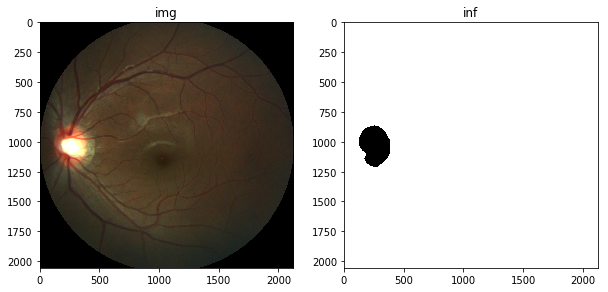

In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

img_path = 'dataset/PALM-Testing400-Images/T0255.jpg'
inf_path = 'Disc_Segmentation/T0255.png'
img = Image.open(img_path)
inf = Image.open(inf_path)
plt.figure(figsize=(10, 5))
plt.subplot(121);plt.imshow(img);plt.title('img')
plt.subplot(122);plt.imshow(inf);plt.title('inf')
plt.show()

## 心得
1. 这个任务也没有下一个分割任务的那样样本不均衡，做起来相对容易，用PaddleSeg很容易就搞定了。
2. 网络也不是说AttUNet就比UNet好，吖吖查大佬说他用的UNet也是第一名，训练的调参也非常重要。

## *参考资料
1. [PaddleSeg](https://gitee.com/paddlepaddle/PaddleSeg)
2. [Patta](https://github.com/AgentMaker/PaTTA)